In [19]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.9 MB/s eta 0:00:00


In [2]:
import os

if not os.path.exists('data'):
    os.makedirs('data')

input_file = 'ind.txt'
output_file = 'data/en-id.tsv'
lines_processed = 0

print("Memulai proses pembersihan data...")

with open(input_file, 'r', encoding='utf-8') as infile, \
     open(output_file, 'w', encoding='utf-8') as outfile:

    for line in infile:
        parts = line.strip().split('\t')

        if len(parts) >= 2:
            english_sentence = parts[0].strip().lower()
            indonesian_sentence = parts[1].strip().lower()

            outfile.write(f"{english_sentence}\t{indonesian_sentence}\n")
            lines_processed += 1

print(f"Proses selesai. Sejumlah {lines_processed} baris telah diproses.")
print(f"Data bersih disimpan di: {output_file}")

Memulai proses pembersihan data...
Proses selesai. Sejumlah 14881 baris telah diproses.
Data bersih disimpan di: data/en-id.tsv


In [3]:
input_tsv = 'data/en-id.tsv'
output_txt = 'data/combined_sentences.txt'

print("Menggabungkan kalimat dari kedua bahasa...")

with open(input_tsv, 'r', encoding='utf-8') as infile, \
     open(output_txt, 'w', encoding='utf-8') as outfile:

    for line in infile:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            # Tulis kalimat bahasa Inggris, lalu di baris baru kalimat bahasa Indonesia
            outfile.write(parts[0] + '\n')
            outfile.write(parts[1] + '\n')

print(f"Selesai. Semua kalimat disimpan di: {output_txt}")

Menggabungkan kalimat dari kedua bahasa...
Selesai. Semua kalimat disimpan di: data/combined_sentences.txt


In [4]:
!pip install sentencepiece

In [5]:
import sentencepiece as spm

# Parameter pelatihan
input_file = 'data/combined_sentences.txt'
model_prefix = 'bpe_model' # Nama untuk file model yang akan disimpan
vocab_size = 8000          # Ukuran vocabulary, ini adalah hyperparameter
model_type = 'bpe'         # Tipe model, bisa juga 'unigram'

command = f'--input={input_file} --model_prefix={model_prefix} --vocab_size={vocab_size} --model_type={model_type}'

print("Memulai pelatihan tokenizer SentencePiece...")

spm.SentencePieceTrainer.train(command)

print("Pelatihan tokenizer selesai.")
print(f"Model disimpan dengan prefix: {model_prefix}")

Memulai pelatihan tokenizer SentencePiece...
Pelatihan tokenizer selesai.
Model disimpan dengan prefix: bpe_model


In [6]:
import random

input_file = 'data/en-id.tsv'
train_file = 'data/train.tsv'
val_file = 'data/val.tsv'
test_file = 'data/test.tsv'

# Baca semua baris dari file
print(f"Membaca data dari {input_file}...")
with open(input_file, 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Acak urutan baris
print("Mengacak data...")
random.seed(42) # Menggunakan seed agar hasil acakan selalu sama
random.shuffle(lines)

# Hitung titik pembagian (80% train, 10% val, 10% test)
total_lines = len(lines)
train_end = int(total_lines * 0.8)
val_end = int(total_lines * 0.9)

# Bagi data
train_data = lines[:train_end]
val_data = lines[train_end:val_end]
test_data = lines[val_end:]

# Fungsi untuk menyimpan data ke file
def save_data(data, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for line in data:
            f.write(line)
    print(f"Menyimpan {len(data)} baris ke {filename}")

# Simpan ketiga set data
save_data(train_data, train_file)
save_data(val_data, val_file)
save_data(test_data, test_file)

print("\nPembagian data selesai!")

Membaca data dari data/en-id.tsv...
Mengacak data...
Menyimpan 11904 baris ke data/train.tsv
Menyimpan 1488 baris ke data/val.tsv
Menyimpan 1489 baris ke data/test.tsv

Pembagian data selesai!


In [12]:
import torch
from torch.utils.data import Dataset
import sentencepiece as spm

# --- Definisi Class Dataset ---
class TranslationDataset(Dataset):
    def __init__(self, tokenizer_path, data_path, max_len=100):
        """
        Inisialisasi Dataset.
        """
        # Muat tokenizer
        self.tokenizer = spm.SentencePieceProcessor()
        self.tokenizer.load(tokenizer_path)

        # Muat data
        self.pairs = []
        with open(data_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    self.pairs.append((parts[0], parts[1]))

        self.max_len = max_len
        # Dapatkan ID untuk token spesial
        self.sos_id = self.tokenizer.bos_id() # Start Of Sentence
        self.eos_id = self.tokenizer.eos_id() # End Of Sentence

        # --- PERBAIKAN DI SINI ---
        # Cek pad_id default dari SentencePiece. Jika -1 (tidak ada),
        # kita gunakan unk_id (biasanya 0) sebagai gantinya.
        self.pad_id = self.tokenizer.pad_id()
        if self.pad_id == -1:
            self.pad_id = self.tokenizer.unk_id()

        print(f"Tokenizer dimuat. PAD ID diatur ke: {self.pad_id}")


    def __len__(self):
        """Mengembalikan jumlah total pasangan kalimat."""
        return len(self.pairs)

    def __getitem__(self, idx):
        """Mengambil sepasang kalimat, lalu mengubahnya menjadi tensor."""
        src_text, tgt_text = self.pairs[idx]

        # Tokenisasi: ubah teks menjadi urutan ID
        src_ids = self.tokenizer.encode_as_ids(src_text)
        tgt_ids = self.tokenizer.encode_as_ids(tgt_text)

        # Tambahkan token SOS dan EOS
        src_ids = [self.sos_id] + src_ids + [self.eos_id]
        tgt_ids = [self.sos_id] + tgt_ids + [self.eos_id]

        # Konversi ke torch.Tensor
        src_tensor = torch.LongTensor(src_ids)
        tgt_tensor = torch.LongTensor(tgt_ids)

        return {
            "source_text": src_text,
            "target_text": tgt_text,
            "source_tensor": src_tensor,
            "target_tensor": tgt_tensor
        }

# --- Jalankan ulang inisialisasi dataset untuk memastikan perubahan diterapkan ---
print("Membuat ulang instance dataset dengan perbaikan...")
try:
    train_dataset = TranslationDataset(
        tokenizer_path='bpe_model.model',
        data_path='data/train.tsv'
    )
    print("\n✅ Dataset berhasil dibuat ulang!")
except Exception as e:
    print(f"\n❌ Gagal: {e}")

Membuat ulang instance dataset dengan perbaikan...
Tokenizer dimuat. PAD ID diatur ke: 0

✅ Dataset berhasil dibuat ulang!


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------- 1. Encoder -------------------
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        """
        Args:
            input_size (int): Ukuran vocabulary sumber.
            hidden_size (int): Ukuran hidden state di GRU.
        """
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input_tensor):
        """
        Args:
            input_tensor (Tensor): Tensor dari ID token sumber, shape: [batch_size, seq_length]

        Returns:
            outputs (Tensor): Output dari GRU untuk setiap timestep, shape: [batch_size, seq_length, hidden_size]
            hidden (Tensor): Hidden state terakhir, shape: [1, batch_size, hidden_size]
        """
        embedded = self.embedding(input_tensor)
        embedded = self.dropout(embedded)

        outputs, hidden = self.gru(embedded)
        return outputs, hidden

# ------------------- 2. Attention Decoder -------------------
# Menggabungkan Attention Mechanism langsung di dalam Decoder
class AttentionDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        """
        Args:
            hidden_size (int): Ukuran hidden state GRU (harus sama dengan Encoder).
            output_size (int): Ukuran vocabulary target.
        """
        super(AttentionDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, batch_first=True) # Inputnya adalah embedding + context vector
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

        # Lapisan untuk menghitung skor attention (Bahdanau-style)
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, decoder_input, decoder_hidden, encoder_outputs):
        """
        Args:
            decoder_input (Tensor): ID token target dari timestep sebelumnya, shape: [batch_size, 1]
            decoder_hidden (Tensor): Hidden state decoder dari timestep sebelumnya, shape: [1, batch_size, hidden_size]
            encoder_outputs (Tensor): Semua output dari encoder, shape: [batch_size, seq_length, hidden_size]

        Returns:
            prediction (Tensor): Probabilitas untuk setiap kata di vocab target, shape: [batch_size, output_size]
            decoder_hidden (Tensor): Hidden state decoder yang baru.
        """
        # 1. Dapatkan embedding dari input decoder saat ini
        embedded = self.embedding(decoder_input) # Shape: [batch_size, 1, hidden_size]
        embedded = self.dropout(embedded)

        # 2. Hitung skor attention
        #    Ubah shape decoder_hidden agar bisa dijumlahkan dengan encoder_outputs
        #    decoder_hidden shape: [1, batch_size, hidden_size] -> [batch_size, 1, hidden_size]
        #    encoder_outputs shape: [batch_size, seq_length, hidden_size]
        scores = self.Va(torch.tanh(self.Wa(decoder_hidden.permute(1, 0, 2)) + self.Ua(encoder_outputs)))
        scores = scores.squeeze(2) # Shape: [batch_size, seq_length]

        # 3. Dapatkan bobot attention dengan softmax
        attention_weights = F.softmax(scores, dim=1) # Shape: [batch_size, seq_length]

        # 4. Hitung context vector
        #    Ubah shape attention_weights agar bisa dikalikan
        #    attention_weights shape: [batch_size, 1, seq_length]
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs) # Shape: [batch_size, 1, hidden_size]

        # 5. Gabungkan embedding input dengan context vector
        rnn_input = torch.cat((embedded, context_vector), dim=2) # Shape: [batch_size, 1, hidden_size * 2]

        # 6. Masukkan ke GRU
        output, decoder_hidden = self.gru(rnn_input, decoder_hidden)

        # 7. Dapatkan prediksi
        prediction = self.out(output.squeeze(1)) # Shape: [batch_size, output_size]

        return prediction, decoder_hidden

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import random
import time

# ------------------- 1. Model Seq2Seq Wrapper -------------------
# Class ini menyatukan Encoder dan Decoder
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        """
        src: [batch_size, src_len]
        trg: [batch_size, trg_len]
        """
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_size

        # Tensor untuk menyimpan output decoder
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # Lewatkan source sentence ke encoder
        encoder_outputs, hidden = self.encoder(src)

        # Ambil token <sos> sebagai input pertama untuk decoder
        decoder_input = trg[:, 0].unsqueeze(1) # Shape: [batch_size, 1]

        for t in range(1, trg_len):
            # Lakukan forward pass pada decoder
            output, hidden = self.decoder(decoder_input, hidden, encoder_outputs)

            # Simpan prediksi
            outputs[:, t, :] = output

            # Tentukan apakah akan menggunakan "teacher forcing"
            teacher_force = random.random() < teacher_forcing_ratio

            # Dapatkan token dengan probabilitas tertinggi
            top1 = output.argmax(1)

            # Siapkan input selanjutnya untuk decoder
            decoder_input = trg[:, t].unsqueeze(1) if teacher_force else top1.unsqueeze(1)

        return outputs


# ------------------- 2. Fungsi Collate untuk Padding -------------------
# DataLoader butuh fungsi ini untuk membuat semua kalimat dalam satu batch punya panjang yang sama
def collate_fn(batch, pad_id):
    sources = [item['source_tensor'] for item in batch]
    targets = [item['target_tensor'] for item in batch]

    # Tambahkan padding
    padded_sources = torch.nn.utils.rnn.pad_sequence(sources, batch_first=True, padding_value=pad_id)
    padded_targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=pad_id)

    return padded_sources, padded_targets


# ------------------- 3. Hyperparameters dan Inisialisasi -------------------
# Cek ketersediaan GPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

INPUT_DIM = len(train_dataset.tokenizer)
OUTPUT_DIM = len(train_dataset.tokenizer)
HIDDEN_DIM = 256
BATCH_SIZE = 64
N_EPOCHS = 10 # Kita coba 10 epoch dulu
LEARNING_RATE = 0.001
PAD_ID = train_dataset.pad_id

# Inisialisasi model
encoder = EncoderRNN(INPUT_DIM, HIDDEN_DIM).to(DEVICE)
decoder = AttentionDecoderRNN(HIDDEN_DIM, OUTPUT_DIM).to(DEVICE)
model = Seq2Seq(encoder, decoder, DEVICE).to(DEVICE)

# Inisialisasi optimizer dan loss function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID) # Abaikan padding saat menghitung loss

# Buat DataLoader
# Kita perlu partial untuk memasukkan argumen pad_id ke collate_fn
from functools import partial
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(collate_fn, pad_id=PAD_ID))


# ------------------- 4. Fungsi Training untuk Satu Epoch -------------------
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0

    for i, (src, trg) in enumerate(dataloader):
        src = src.to(DEVICE)
        trg = trg.to(DEVICE)

        optimizer.zero_grad()

        output = model(src, trg) # output shape: [batch_size, trg_len, output_dim]

        # Reshape output dan target untuk CrossEntropyLoss
        # output -> [batch_size * (trg_len - 1), output_dim]
        # trg -> [batch_size * (trg_len - 1)]
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()

        # Clip gradient untuk mencegah exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


# ------------------- 5. Loop Pelatihan Utama -------------------
print("Memulai pelatihan model baseline (RNN + Attention)...")
for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train_epoch(model, train_dataloader, optimizer, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    print(f'Epoch: {epoch+1:02} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
    print(f'\tTrain Loss: {train_loss:.3f}')

Memulai pelatihan model baseline (RNN + Attention)...
Epoch: 01 | Time: 4m 20s
	Train Loss: 5.416
Epoch: 02 | Time: 4m 23s
	Train Loss: 4.550
Epoch: 03 | Time: 4m 29s
	Train Loss: 3.990
Epoch: 04 | Time: 4m 7s
	Train Loss: 3.541
Epoch: 05 | Time: 4m 12s
	Train Loss: 3.140
Epoch: 06 | Time: 4m 5s
	Train Loss: 2.784
Epoch: 07 | Time: 4m 13s
	Train Loss: 2.455
Epoch: 08 | Time: 4m 52s
	Train Loss: 2.179
Epoch: 09 | Time: 4m 18s
	Train Loss: 1.945
Epoch: 10 | Time: 4m 0s
	Train Loss: 1.735


In [14]:
import torch
import torch.nn as nn
import math

# ------------------- 1. Positional Encoding -------------------
# Transformer tidak punya pemahaman urutan, jadi kita harus 'menyuntikkan'
# informasi posisi ke dalam input embedding.
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# ------------------- 2. Model Transformer -------------------
class TransformerTranslator(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers,
                 num_decoder_layers, dim_feedforward, dropout=0.1):
        super(TransformerTranslator, self).__init__()

        # Lapisan Embedding (sama untuk source dan target)
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # Modul Transformer utama dari PyTorch
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # Penting! Kita akan menggunakan batch_first
        )

        # Lapisan output linear
        self.fc_out = nn.Linear(d_model, vocab_size)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, tgt, src_padding_mask, tgt_padding_mask, memory_key_padding_mask, tgt_mask):
        """
        src: [batch_size, src_len]
        tgt: [batch_size, tgt_len]
        ...masks...
        """
        # 1. Embedding & Positional Encoding
        src_emb = self.embedding(src) * math.sqrt(self.d_model)
        tgt_emb = self.embedding(tgt) * math.sqrt(self.d_model)

        # Ubah shape dari [batch_size, seq_len, d_model] menjadi [seq_len, batch_size, d_model]
        # Hapus baris ini jika menggunakan batch_first=True
        # src_emb = self.pos_encoder(src_emb.permute(1,0,2))
        # tgt_emb = self.pos_encoder(tgt_emb.permute(1,0,2))

        # PyTorch Transformer dengan batch_first=True tidak butuh permute
        src_emb = self.pos_encoder(src_emb)
        tgt_emb = self.pos_encoder(tgt_emb)

        # 2. Forward pass ke Transformer
        output = self.transformer(src_emb, tgt_emb,
                                  tgt_mask=tgt_mask,
                                  src_key_padding_mask=src_padding_mask,
                                  tgt_key_padding_mask=tgt_padding_mask,
                                  memory_key_padding_mask=memory_key_padding_mask)

        # 3. Lapisan output
        # Hapus baris ini jika menggunakan batch_first=True
        # output = self.fc_out(output.permute(1,0,2))
        output = self.fc_out(output)

        return output

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import time
from functools import partial

# ------------------- 1. Hyperparameters dan Inisialisasi -------------------
# Pastikan DEVICE dan PAD_ID sudah ada dari langkah sebelumnya
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# PAD_ID = train_dataset.pad_id

VOCAB_SIZE = len(train_dataset.tokenizer)
D_MODEL = 256        # Dimensi embedding & model
NHEAD = 8            # Jumlah 'heads' dalam multi-head attention
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DIM_FEEDFORWARD = 512
BATCH_SIZE = 64
N_EPOCHS = 10 # Kita latih 10 epoch juga untuk perbandingan
LEARNING_RATE = 0.0001 # Transformer biasanya butuh learning rate lebih kecil

# Inisialisasi model Transformer
transformer_model = TransformerTranslator(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
).to(DEVICE)

# Inisialisasi optimizer dan loss function (sama seperti sebelumnya)
optimizer = optim.Adam(transformer_model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)

# Buat ulang DataLoader jika perlu (seharusnya masih ada di memori)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(collate_fn, pad_id=PAD_ID))


# ------------------- 2. Fungsi Training untuk Satu Epoch -------------------
def train_epoch_transformer(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0

    for i, (src, trg) in enumerate(dataloader):
        src = src.to(DEVICE)
        trg = trg.to(DEVICE)

        # Kita perlu memisahkan input dan output untuk decoder
        # Input: semua kata kecuali yang terakhir
        # Output target: semua kata kecuali yang pertama (<sos>)
        trg_input = trg[:, :-1]
        trg_output = trg[:, 1:]

        # Buat mask
        src_padding_mask = (src == PAD_ID).to(DEVICE)
        tgt_padding_mask = (trg_input == PAD_ID).to(DEVICE)

        tgt_len = trg_input.shape[1]
        tgt_mask = model._generate_square_subsequent_mask(tgt_len).to(DEVICE)

        optimizer.zero_grad()

        # Forward pass
        output = model(src=src,
                       tgt=trg_input,
                       src_padding_mask=src_padding_mask,
                       tgt_padding_mask=tgt_padding_mask,
                       memory_key_padding_mask=src_padding_mask,
                       tgt_mask=tgt_mask)

        # Reshape untuk loss function
        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)
        trg_output = trg_output.reshape(-1)

        loss = criterion(output, trg_output)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


# ------------------- 3. Loop Pelatihan Utama -------------------
print("Memulai pelatihan model Transformer...")
for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train_epoch_transformer(transformer_model, train_dataloader, optimizer, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    print(f'Epoch: {epoch+1:02} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
    print(f'\tTrain Loss: {train_loss:.3f}')

Memulai pelatihan model Transformer...


/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 01 | Time: 4m 46s
	Train Loss: 5.950
Epoch: 02 | Time: 4m 35s
	Train Loss: 4.850
Epoch: 03 | Time: 4m 38s
	Train Loss: 4.591
Epoch: 04 | Time: 4m 43s
	Train Loss: 4.391
Epoch: 05 | Time: 4m 34s
	Train Loss: 4.228
Epoch: 06 | Time: 4m 35s
	Train Loss: 4.080
Epoch: 07 | Time: 4m 41s
	Train Loss: 3.943
Epoch: 08 | Time: 4m 40s
	Train Loss: 3.822
Epoch: 09 | Time: 4m 32s
	Train Loss: 3.706
Epoch: 10 | Time: 4m 33s
	Train Loss: 3.592


In [16]:
def translate_sentence_transformer(sentence, model, tokenizer, device, max_len=50):
    # Set model ke mode evaluasi
    model.eval()

    # 1. Tokenisasi kalimat sumber dan tambahkan token SOS/EOS
    src_ids = [tokenizer.bos_id()] + tokenizer.encode_as_ids(sentence) + [tokenizer.eos_id()]
    src_tensor = torch.LongTensor(src_ids).unsqueeze(0).to(device) # Shape: [1, src_len]

    # 2. Buat source padding mask
    src_padding_mask = (src_tensor == PAD_ID).to(device)

    # 3. Inisialisasi target dengan token SOS
    tgt_ids = [tokenizer.bos_id()]

    # 4. Loop untuk menghasilkan token satu per satu
    for i in range(max_len):
        tgt_tensor = torch.LongTensor(tgt_ids).unsqueeze(0).to(device) # Shape: [1, current_tgt_len]

        # Buat target mask
        tgt_len = tgt_tensor.shape[1]
        tgt_mask = model._generate_square_subsequent_mask(tgt_len).to(device)
        tgt_padding_mask = (tgt_tensor == PAD_ID).to(device) # Sebenarnya tidak perlu untuk target di inferensi

        # Dapatkan prediksi dari model
        with torch.no_grad():
            output = model(src=src_tensor,
                           tgt=tgt_tensor,
                           src_padding_mask=src_padding_mask,
                           tgt_padding_mask=tgt_padding_mask,
                           memory_key_padding_mask=src_padding_mask,
                           tgt_mask=tgt_mask)

        # Ambil token terakhir yang diprediksi (greedy search)
        pred_token_id = output.argmax(2)[:, -1].item()

        # Tambahkan token ke urutan target
        tgt_ids.append(pred_token_id)

        # Jika token adalah EOS, hentikan proses
        if pred_token_id == tokenizer.eos_id():
            break

    # 5. Ubah urutan ID kembali menjadi teks
    translation = tokenizer.decode(tgt_ids[1:]) # Hapus token SOS di awal
    return translation

# --- Contoh Penggunaan ---
# Pilih sebuah kalimat untuk diterjemahkan
sample_sentence = "a group of people are playing football."

# Lakukan terjemahan
translation_result = translate_sentence_transformer(sample_sentence, transformer_model, train_dataset.tokenizer, DEVICE)

print(f"Kalimat Sumber: {sample_sentence}")
print(f"Hasil Terjemahan (Transformer): {translation_result}")

Kalimat Sumber: a group of people are playing football.
Hasil Terjemahan (Transformer): orang-orang itu adalah seorang orang yang baik.


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


In [22]:
import sacrebleu
from tqdm import tqdm

# ------------------- 1. Fungsi Translate untuk Model RNN -------------------
def translate_sentence_rnn(sentence, model, tokenizer, device, max_len=50):
    model.eval()

    src_ids = [tokenizer.bos_id()] + tokenizer.encode_as_ids(sentence) + [tokenizer.eos_id()]
    src_tensor = torch.LongTensor(src_ids).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    tgt_ids = [tokenizer.bos_id()]

    for i in range(max_len):
        # --- PERBAIKAN DI SINI ---
        # Ubah shape input menjadi [1, 1] agar konsisten dengan training batch
        tgt_tensor = torch.LongTensor([[tgt_ids[-1]]]).to(device)

        with torch.no_grad():
            output, hidden = model.decoder(tgt_tensor, hidden, encoder_outputs)

        pred_token_id = output.argmax(1).item()
        tgt_ids.append(pred_token_id)

        if pred_token_id == tokenizer.eos_id():
            break

    translation = tokenizer.decode(tgt_ids[1:])
    return translation

# ------------------- 2. Fungsi Evaluasi Utama (Tetap sama) -------------------
def evaluate_model(model, tokenizer, test_data_path, translate_function, device):
    print(f"\nMemulai evaluasi untuk model: {model.__class__.__name__}...")

    # Baca test set
    targets = [] # Terjemahan referensi (sebenarnya)
    sources = [] # Kalimat sumber
    with open(test_data_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                sources.append(parts[0])
                targets.append(parts[1])

    # Hasilkan terjemahan (hipotesis)
    hypotheses = []
    for src in tqdm(sources, desc="Menerjemahkan test set"):
        translation = translate_function(src, model, tokenizer, device)
        hypotheses.append(translation)

    # Hitung BLEU score
    bleu = sacrebleu.corpus_bleu(hypotheses, [targets])

    return bleu.score

# ------------------- 3. Jalankan Evaluasi untuk Kedua Model (Tetap sama) -------------------
TEST_DATA_PATH = 'data/test.tsv'

# Evaluasi model RNN Baseline
bleu_rnn = evaluate_model(model, train_dataset.tokenizer, TEST_DATA_PATH, translate_sentence_rnn, DEVICE)
print(f"✅ SKOR BLEU (RNN Baseline): {bleu_rnn:.2f}")

# Evaluasi model Transformer
bleu_transformer = evaluate_model(transformer_model, train_dataset.tokenizer, TEST_DATA_PATH, translate_sentence_transformer, DEVICE)
print(f"✅ SKOR BLEU (Transformer): {bleu_transformer:.2f}")


Memulai evaluasi untuk model: Seq2Seq...


Menerjemahkan test set: 100%|██████████| 1489/1489 [00:17<00:00, 86.64it/s] 


✅ SKOR BLEU (RNN Baseline): 21.50

Memulai evaluasi untuk model: TransformerTranslator...


Menerjemahkan test set: 100%|██████████| 1489/1489 [02:05<00:00, 11.91it/s]


✅ SKOR BLEU (Transformer): 5.96


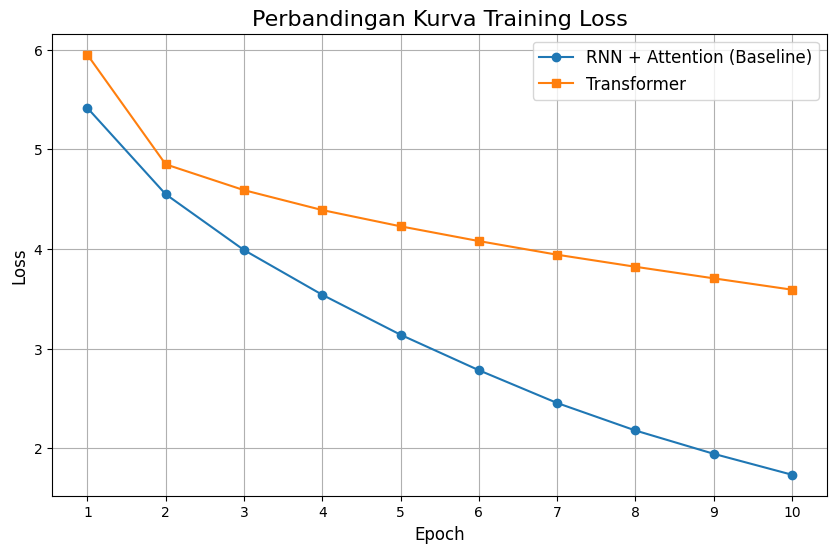

In [23]:
import matplotlib.pyplot as plt

# 1. Data loss yang Anda dapatkan dari hasil training
epochs = range(1, 11)
rnn_losses = [5.416, 4.550, 3.990, 3.541, 3.140, 2.784, 2.455, 2.179, 1.945, 1.735]
transformer_losses = [5.950, 4.850, 4.591, 4.391, 4.228, 4.080, 3.943, 3.822, 3.706, 3.592]

# 2. Membuat plot
plt.figure(figsize=(10, 6)) # Mengatur ukuran gambar

plt.plot(epochs, rnn_losses, 'o-', label='RNN + Attention (Baseline)')
plt.plot(epochs, transformer_losses, 's-', label='Transformer')

# 3. Memberi judul dan label
plt.title('Perbandingan Kurva Training Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(epochs) # Memastikan semua epoch ditampilkan di sumbu x
plt.legend(fontsize=12)
plt.grid(True) # Menambahkan grid untuk kemudahan membaca

# 4. Menyimpan dan menampilkan gambar
plt.savefig('kurva_pelatihan.png') # Menyimpan gambar ke file
plt.show() # Menampilkan gambar di output Colab